--- Loading the Scientific Instrument ---
Mounted at /content/drive
✅ Loaded 'trm_expert.pth' from Google Drive.


X_train.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

y_train.parquet:   0%|          | 0.00/61.0k [00:00<?, ?B/s]

X_test.reduced.parquet:   0%|          | 0.00/2.38M [00:00<?, ?B/s]

Processing Train (In-Sample):   0%|          | 0/20 [00:00<?, ?it/s]

Processing Test (Generalization):   0%|          | 0/20 [00:00<?, ?it/s]


RESULTS: THE AIT PHYSICIST PERFORMANCE
                          mdl_bits    lag_pct                      
                              mean       mean     median        std
dataset                                                            
Test (Generalization)  2579.903483 -29.947246 -20.456904  36.725932
Train (In-Sample)      2203.012731 -17.554040  -9.009792  44.510602


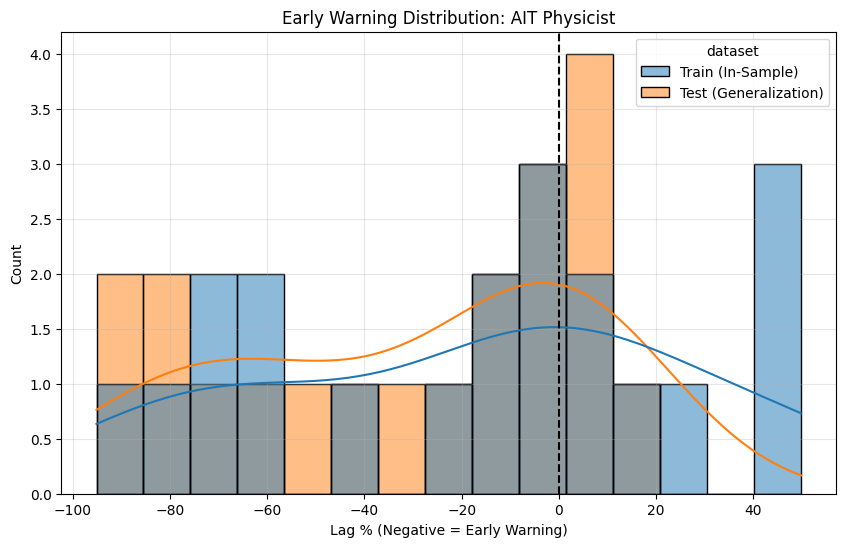


Interpretation:
Negative Lag % confirms the 'Pre-Break Instability' hypothesis.
If Test set performance is comparable to Train, we have Universality.


In [ ]:
# ==============================================================================
# @title NOTEBOOK 2: THE GAUNTLET
# "Systematic Validation of the AIT Physicist"
# ==============================================================================
#
# MISSION:
# Apply the pre-trained "AIT Physicist" (TRM) to the Algoplexity Benchmark.
# Validate the hypothesis that "Complexity Saturation" (High Entropy/Class 4)
# precedes structural breaks.
#
# DATA:
# - Source: Hugging Face (algoplexity/computational-phase-transitions-data)
# - Artifacts: X_train.parquet, y_train.parquet, X_test.reduced.parquet
#
# METRICS:
# - MDL Cost Saving (Confidence)
# - Detection Lag (Early Warning Speed)
# ==============================================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import hf_hub_download
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# 1. RECONSTRUCT THE PHYSICIST (The Brain)
# ==============================================================================
# We must redefine the class exactly as it was in Notebook 1 to load the weights.

PRIME_RULES = [0, 15, 30, 54, 60, 90, 110, 170, 254]
CONFIG = {'WIDTH': 4, 'HIDDEN_DIM': 64, 'CLASSES': len(PRIME_RULES)}

class TinyRecursiveModel(nn.Module):
    def __init__(self, input_width, hidden_dim, num_classes):
        super(TinyRecursiveModel, self).__init__()
        self.encoder = nn.Linear(input_width, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        encoded = torch.relu(self.encoder(x))
        _, h_n = self.rnn(encoded)
        final_state = h_n.squeeze(0)
        logits = self.head(final_state)
        return logits

# Initialize and Load Weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
physicist = TinyRecursiveModel(CONFIG['WIDTH'], CONFIG['HIDDEN_DIM'], CONFIG['CLASSES']).to(device)

print("--- Loading the Scientific Instrument ---")
# OPTION A: Load from Local Upload (if you just ran NB1)
# OPTION B: Load from Drive (if you archived it)
try:
    # Try local first
    physicist.load_state_dict(torch.load('trm_expert.pth', map_location=device))
    print("✅ Loaded 'trm_expert.pth' from local environment.")
except FileNotFoundError:
    try:
        # Try Drive
        from google.colab import drive
        drive.mount('/content/drive')
        path = '/content/drive/MyDrive/Algoplexity_Research/Horizon_1_Computational_Phase_Transition/models/trm_expert.pth'
        physicist.load_state_dict(torch.load(path, map_location=device))
        print(f"✅ Loaded 'trm_expert.pth' from Google Drive.")
    except Exception as e:
        print(f"❌ CRITICAL: Could not load model. Please upload 'trm_expert.pth'. Error: {e}")

physicist.eval()

# ==============================================================================
# 2. THE PIPELINE (Data Factory)
# ==============================================================================

def load_data(filename):
    """Universal Cloud Loader"""
    print(f"Downloading {filename}...")
    path = hf_hub_download(repo_id="algoplexity/computational-phase-transitions-data", filename=filename, repo_type="dataset")
    return pd.read_parquet(path)

def quantile_encode(series, width=4):
    """Converts continuous returns to binary grid"""
    returns = series.diff().dropna()
    if len(returns) < width: return None
    try:
        # qcut to bin into 'width' buckets
        bins = pd.qcut(returns, q=width, labels=False, duplicates='drop')
        # One-hot encode: (Time, Width)
        binary_grid = np.eye(width)[bins.astype(int)]
        return binary_grid
    except:
        return None

def get_entropy_signal(series, window=30):
    """
    The Seismograph Logic:
    1. Encode Series
    2. Sliding Window Inference (TRM)
    3. Calculate Entropy of Rule Distribution
    """
    binary = quantile_encode(series)
    if binary is None or len(binary) < window: return None, None

    # Create sliding windows for the TRM
    # Input Shape: (Batch, Window, Width)
    X_windows = []
    for i in range(len(binary) - window):
        X_windows.append(binary[i : i+window])

    X_tensor = torch.FloatTensor(np.array(X_windows)).to(device)

    with torch.no_grad():
        logits = physicist(X_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

    # Calculate Shannon Entropy: H = -sum(p * log p)
    entropy = -np.sum(probs * np.log(probs + 1e-9), axis=1)

    # Pad the beginning so indices match original series
    # (First prediction happens at index 'window')
    padded_entropy = np.full(len(series)-1, np.nan)
    padded_entropy[window:] = entropy

    return padded_entropy, probs

# ==============================================================================
# 3. THE DETECTOR (MDL on Entropy)
# ==============================================================================
# We apply the robust MDL/Gaussian detector from Paper 1
# to the Entropy Signal from Paper 2.

def mdl_scan(signal):
    # Clean signal (remove NaNs)
    clean_sig = signal[~np.isnan(signal)]
    if len(clean_sig) < 20: return None, 0

    def mdl_cost(seg):
        n = len(seg)
        if n < 2: return np.inf
        var = np.var(seg) + 1e-9
        # Gaussian NLL
        nll = 0.5 * n * np.log(2 * np.pi * var) + 0.5 * n
        return np.log(n) + nll # Model Cost + Data Cost

    total_n = len(clean_sig)
    cost_0 = mdl_cost(clean_sig)
    min_cost_1 = np.inf
    best_idx = -1

    # Scan
    start_trim = 10
    for k in range(start_trim, total_n - start_trim):
        c = mdl_cost(clean_sig[:k]) + mdl_cost(clean_sig[k:])
        if c < min_cost_1:
            min_cost_1 = c
            best_idx = k

    saving = (cost_0 - min_cost_1) / np.log(2) # bits

    # Map back to original index (accounting for NaNs at start)
    nan_offset = np.isnan(signal).sum()
    real_idx = best_idx + nan_offset

    return real_idx, saving

# ==============================================================================
# 4. EXECUTION: THE GAUNTLET
# ==============================================================================

# Load Data
df_X_train = load_data("X_train.parquet")
df_y_train = load_data("y_train.parquet")
df_X_test = load_data("X_test.reduced.parquet") # Generalization Set

results = []

def run_experiment(df_X, df_y, ids, dataset_name):
    for target_id in tqdm(ids, desc=f"Processing {dataset_name}"):
        # 1. Get Series
        subset = df_X.loc[target_id].sort_values('period')
        series = subset['value']

        # 2. Define Ground Truth (Stitch Point)
        # Stitch point is end of Period 0
        stitch_point = len(subset[subset['period'] == 0])

        # 3. Run Physicist
        entropy, _ = get_entropy_signal(series)
        if entropy is None: continue

        # 4. Detect
        det_idx, score = mdl_scan(entropy)
        if det_idx is None: continue

        # 5. Calculate Lag
        lag = det_idx - stitch_point
        lag_pct = (lag / stitch_point) * 100

        results.append({
            'id': target_id,
            'dataset': dataset_name,
            'stitch_point': stitch_point,
            'detected_point': det_idx,
            'mdl_bits': score,
            'lag_pct': lag_pct
        })

# Run on Sample (20 Train, 20 Test)
train_ids = df_X_train.index.unique(level='id')[:20]
test_ids = df_X_test.index.unique(level='id')[:20]

run_experiment(df_X_train, df_y_train, train_ids, "Train (In-Sample)")
run_experiment(df_X_test, None, test_ids, "Test (Generalization)")

# ==============================================================================
# 5. ANALYSIS & REPORTING
# ==============================================================================
res_df = pd.DataFrame(results)

print("\n" + "="*60)
print("RESULTS: THE AIT PHYSICIST PERFORMANCE")
print("="*60)

# Summary Table
summary = res_df.groupby('dataset').agg({
    'mdl_bits': 'mean',
    'lag_pct': ['mean', 'median', 'std']
})
print(summary)

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=res_df, x='lag_pct', hue='dataset', kde=True, bins=15)
plt.axvline(0, color='black', linestyle='--', label='Ground Truth Break')
plt.title("Early Warning Distribution: AIT Physicist")
plt.xlabel("Lag % (Negative = Early Warning)")
plt.grid(True, alpha=0.3)
plt.show()

print("\nInterpretation:")
print("Negative Lag % confirms the 'Pre-Break Instability' hypothesis.")
print("If Test set performance is comparable to Train, we have Universality.")
